# Part 1 - Training a Classifier

In [33]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import time
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F

In [34]:
classifier_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_data = datasets.MNIST(root='data', train=True, download=True, transform=classifier_transform)

batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [35]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, time_embedding_dim=128):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 6 * 6, 128)  
        self.fc2 = nn.Linear(128 + time_embedding_dim, num_classes)  # Add time embedding

        self.time_embedding = nn.Linear(1, time_embedding_dim)  # Learn timestep embedding

    def forward(self, x, t):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Embed timestep t
        t = t.float().unsqueeze(1)  # Shape: (batch_size, 1)
        t_emb = F.relu(self.time_embedding(t))  # Transform timestep into vector

        # Concatenate image features and timestep embedding
        x = torch.cat([x, t_emb], dim=1)

        # Final classification
        x = self.fc2(x)
        return x


In [39]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, and optimizer
classifier = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 50

In [40]:
import torch
import time
from diffusers import DDPMScheduler

start_time = time.time()

# Initialize the DDPM Noise Scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,  # Number of diffusion steps
    beta_schedule="linear"
)

for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        data, targets = data.to(device), targets.to(device)

        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (data.shape[0],), device=device).long()

        # Generate random Gaussian noise
        noise = torch.randn_like(data).to(device)

        # Get the noisy images using diffusers' add_noise function
        noisy_images = noise_scheduler.add_noise(data, noise, timesteps)

        # Forward pass with noisy images and timesteps
        outputs = classifier(noisy_images, timesteps)
        
        # Compute loss and optimize
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    epoch_loss = running_loss / len(train_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}, Accuracy: {100 * correct / total:.2f}%')

    # Update learning rate scheduler (if one is defined)
    if "lr_scheduler" in globals():  # Check if lr_scheduler exists
        lr_scheduler.step()

end_time = time.time()


Epoch [1/50], Loss: 7.06983, Accuracy: 16.77%
Epoch [2/50], Loss: 1.68056, Accuracy: 43.47%
Epoch [3/50], Loss: 1.51156, Accuracy: 47.53%
Epoch [4/50], Loss: 1.40502, Accuracy: 50.25%
Epoch [5/50], Loss: 1.39353, Accuracy: 50.71%
Epoch [6/50], Loss: 1.39703, Accuracy: 50.60%
Epoch [7/50], Loss: 1.37534, Accuracy: 51.12%
Epoch [8/50], Loss: 1.37611, Accuracy: 51.09%
Epoch [9/50], Loss: 1.38078, Accuracy: 50.98%
Epoch [10/50], Loss: 1.37434, Accuracy: 51.29%
Epoch [11/50], Loss: 1.37209, Accuracy: 51.22%
Epoch [12/50], Loss: 1.37450, Accuracy: 51.08%
Epoch [13/50], Loss: 1.37384, Accuracy: 51.30%
Epoch [14/50], Loss: 1.37750, Accuracy: 51.29%
Epoch [15/50], Loss: 1.37825, Accuracy: 51.09%
Epoch [16/50], Loss: 1.38059, Accuracy: 51.15%
Epoch [17/50], Loss: 1.37732, Accuracy: 51.27%
Epoch [18/50], Loss: 1.37136, Accuracy: 51.37%
Epoch [19/50], Loss: 1.37687, Accuracy: 51.24%
Epoch [20/50], Loss: 1.38116, Accuracy: 51.16%
Epoch [21/50], Loss: 1.37597, Accuracy: 51.40%
Epoch [22/50], Loss: 1

# Part 2 - Train Unconditional Diffusion model

In [41]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from diffusers import DDPMScheduler, UNet2DModel


classifier.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
image_size = 32  # Ensure image size is a multiple of 2
batch_size = 128
learning_rate = 1e-4
num_epochs = 10

# Data preparation
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize MNIST images to 32x32
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 2) - 1)
])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model setup
model = UNet2DModel(
    sample_size=image_size,  # Input image size
    in_channels=1,           # Input channels (grayscale for MNIST)
    out_channels=1,          # Output channels
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
).to(device)

# Scheduler setup
scheduler = DDPMScheduler(
    num_train_timesteps=1000,  # Number of diffusion steps
    beta_schedule="linear"
)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Loss function
criterion = nn.MSELoss()

# Training loop
for epoch in range(num_epochs):
    total = 0
    for batch in train_loader:
        images, _ = batch
        images = images.to(device)

        # Sample noise to add to the images
        noise = torch.randn_like(images).to(device)

        # Sample a random timestep for each image
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (images.shape[0],), device=device).long()

        # Get the noisy images
        noisy_images = scheduler.add_noise(original_samples=images, noise=noise, timesteps=timesteps)

        # Get the model's prediction
        noise_pred = model(noisy_images, timesteps).sample

        # Compute the loss
        loss = criterion(noise_pred, noise)
        total += loss
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total.item():.4f}")



Epoch [1/10], Loss: 25.4801
Epoch [2/10], Loss: 11.0812
Epoch [3/10], Loss: 9.6317
Epoch [4/10], Loss: 9.0368
Epoch [5/10], Loss: 8.6247
Epoch [6/10], Loss: 8.3574
Epoch [7/10], Loss: 8.1925
Epoch [8/10], Loss: 7.9624
Epoch [9/10], Loss: 7.8000
Epoch [10/10], Loss: 7.6860


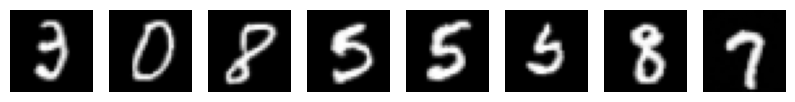

In [42]:
# Sampling process after training
model.eval()
with torch.no_grad():
    num_samples = 8
    # Start from pure noise
    samples = torch.randn((num_samples, 1, image_size, image_size)).to(device)

    # Iterate over timesteps to denoise
    for t in range(scheduler.config.num_train_timesteps - 1, -1, -1):
        timesteps = torch.full((num_samples,), t, device=device, dtype=torch.long)
        # Predict the noise at timestep t
        noise_pred = model(samples, timesteps).sample
        # Get the previous sample using the scheduler
        samples = scheduler.step(noise_pred, t, samples).prev_sample

    # Convert to numpy for visualization
    samples = (samples.clamp(-1, 1) + 1) / 2  # Rescale to [0, 1]
    samples = samples.cpu().numpy()*255.0

# Display sampled images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(samples[i, 0], cmap="gray")
    plt.axis("off")
plt.show()

# Part 3 - Classifier Guided Inference

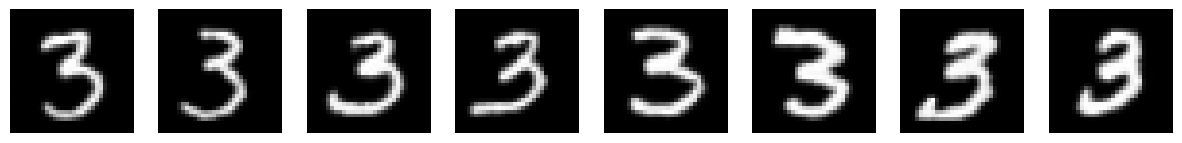

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Classifier-guided sampling function
def classifier_guided_sampling(model, scheduler, classifier, num_samples=8, guidance_scale=10.0, target_class=0, image_size=32):
    model.eval()
    classifier.eval()
    with torch.no_grad():
        # Start from pure noise
        samples = torch.randn((num_samples, 1, image_size, image_size)).to(device)
        
        # Iterate over timesteps to denoise
        for t in range(scheduler.config.num_train_timesteps - 1, -1, -1):
            timesteps = torch.full((num_samples,), t, device=device, dtype=torch.long)
            
            # Predict the noise at timestep t
            noise_pred = model(samples, timesteps).sample
            
            # Classifier guidance
            if t > 0:
                # Enable gradient computation for samples
                samples.requires_grad_(True)
                with torch.enable_grad():
                    # Get classifier logits
                    logits = classifier(samples, timesteps)
                    # Compute the log-probability for the target class
                    log_prob = F.log_softmax(logits, dim=1)[:, target_class].sum()
                    # Compute the gradient of the log-probability w.r.t. samples
                    grad = torch.autograd.grad(log_prob, samples)[0]
                
                # Adjust the noise prediction using the gradient
                noise_pred = noise_pred - guidance_scale *  grad
                
                # Detach samples from the computation graph to avoid memory leaks
                samples = samples.detach()
            
            # Get the previous sample using the scheduler
            samples = scheduler.step(noise_pred, t, samples).prev_sample
            
        # Convert to numpy for visualization
        samples = (samples.clamp(-1, 1) + 1) / 2  # Rescale to [0, 1]
        samples = samples.cpu().numpy() * 255.0  # Scale to [0, 255]

    return samples

# Generate samples with classifier guidance
guidance_scale = 12  # Controls the strength of the classifier guidance
target_class = 3  # Generate samples of class "5"
num_samples = 8  # Number of samples to generate

generated_images = classifier_guided_sampling(model, scheduler, classifier, num_samples, guidance_scale, target_class)

# Plot the generated images
def plot_images(images, nrow=4):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    for i, img in enumerate(images):
        axes[i].imshow(img.squeeze(), cmap="gray")
        axes[i].axis("off")
    plt.show()

plot_images(generated_images)